In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)

In [2]:
pd.set_option('display.float_format', '{:.2%}'.format)

tickers = ['F','META','NVDA','TSLA','SHOP']
start_date = '2024-01-01'
end_date = '2025-04-24'

data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close'][tickers]
rt = data.pct_change().dropna()

mu = rt.mean() * 252
sigma = rt.std() * np.sqrt(252)

metricas = pd.DataFrame({
    'Rendimiento': mu,
    'Volatilidad': sigma,
})
metricas.T

YF.download() has changed argument auto_adjust default to True


Ticker,F,META,NVDA,TSLA,SHOP
Rendimiento,-2.00%,39.39%,75.47%,23.93%,32.94%
Volatilidad,37.21%,39.62%,58.53%,68.95%,58.21%


In [3]:
pd.reset_option('display.float_format')
prices_df = pd.DataFrame({
    'Precio Final': data.iloc[-1],
})
prices_df.T

Ticker,F,META,NVDA,TSLA,SHOP
Precio Final,9.78,520.27002,102.709999,250.740005,90.959999


In [4]:
strikes = [10, 530, 105, 240, 95]

In [5]:
class OptionPayoff:
    def __init__(self) -> None:
        pass

    @staticmethod
    def long_call_payoff(st, k, premium):
        return np.maximum(st - k, 0) - premium
    
    @staticmethod
    def short_call_payoff(st, k, premium):
        return premium - np.maximum(st - k, 0)
    
    @staticmethod
    def long_put_payoff(st, k, premium):
        return np.maximum(k - st, 0) - premium
    
    @staticmethod
    def short_put_payoff(st, k, premium):
        return premium - np.maximum(k - st, 0)

In [6]:
class MultiStraddle:
    def __init__(self, tickers, start_date, end_date, strikes, n_sims=100_000):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.strikes = strikes
        self.n_sims = n_sims
        self.option = OptionPayoff()

        self.data = yf.download(self.tickers, self.start_date, self.end_date, progress=False)['Close'][self.tickers]
        self.rt = self.data.pct_change().dropna()
        self.mu = self.rt.mean().values
        self.sigma = self.rt.std().values
        self.anual_sigma = self.sigma * np.sqrt(252)
        self.last_price = self.data.iloc[-1].values

    def simulate_price_normal(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims, 252))
        returns = mu + sigma * Z
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns
    
    def simulate_price(self, mu, sigma, last_price):
        Z = np.random.normal(size=(self.n_sims // 2, 252))
        Z_antithetic = -Z
        Z_full = np.vstack((Z, Z_antithetic))
        returns = mu + sigma * Z_full
        cumulative_returns = (returns + 1).cumprod(axis=1)
        return last_price * cumulative_returns

    def black_scholes_price(self, So, K, T, rf, sigma, option_type='call'):
        d1 = (np.log(So / K) + (rf + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = (So * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-rf * T) * norm.cdf(d2, 0.0, 1.0))
        else:
            price = (K * np.exp(-rf * T) * norm.cdf(-d2, 0.0, 1.0) - So * norm.cdf(-d1, 0.0, 1.0))
        return price

    def american_option_price(self, So, K, T, rf, sigma, n, option_type='call'):
        dt = T / n
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        disc = np.exp(-rf * dt)
        p = (np.exp(rf * dt) - d) / (u - d)
        j = np.arange(n + 1)
        ST = So * (u ** (n - j)) * (d ** j)

        option_values = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)

        for i in range(n - 1, -1, -1):
            ST = ST[:-1] / u
            option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
            exercise = np.maximum(K - ST, 0.0) if option_type == 'put' else np.maximum(ST - K, 0.0)
            option_values = np.maximum(option_values, exercise)

        return option_values[0]

    def straddle_payoff(self, st, k, premium_call, premium_put):
        return np.maximum(st - k, 0) - premium_call + np.maximum(k - st, 0) - premium_put

    def plot_simulations(self, prices, ticker):
        plt.figure(figsize=(8, 4))
        plt.plot(prices[:5000, :].T)
        plt.title(f'Simulated Price Paths for {ticker}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.show()

    def plot_payoffs(self, st, long_calls, long_puts, strat_payoff, ticker):
        plt.figure(figsize=(10, 6))
        plt.plot(st, long_calls, label='Long Call Payoff', linestyle='--', color='indianred', alpha=0.5)
        plt.plot(st, long_puts, label='Long Put Payoff', linestyle='--', color='navy', alpha=0.5)
        plt.plot(st, strat_payoff, label='Strategy Payoff', color='black')
        plt.title(f'Payoff Diagrams {ticker}')
        plt.xlabel('Stock Price at Expiration')
        plt.ylabel('Payoff')
        plt.legend()
        plt.grid()
        plt.show()

    def execute(self, periods=[20, 62, 125, 251], times=[1/12, 1/4, 1/2, 1]):
        rows = 10_000
        st = np.linspace(0, 800, rows)

        for i in range(len(self.tickers)):
            ticker = self.tickers[i]
            prices = self.simulate_price(self.mu[i], self.sigma[i], self.last_price[i])
            display(HTML(f"<span style='font-size:20px'>{ticker}</span>"))
            self.plot_simulations(prices, ticker)

            for p, t in zip(periods, times):
                k = self.strikes[i]
                premium_call = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'call')
                premium_put = self.black_scholes_price(self.last_price[i], k, t, 0.04, self.anual_sigma[i], 'put')

                long_call = self.option.long_call_payoff(st[:, None], k, premium_call)
                long_put = self.option.long_put_payoff(st[:, None], k, premium_put)
                strat_payoff = self.straddle_payoff(st[:, None], k, premium_call, premium_put)

                self.plot_payoffs(st, long_call, long_put, strat_payoff, ticker)

                final_prices = prices[:, p]
                profits = self.straddle_payoff(final_prices, k, premium_call, premium_put)
                expected_profit = np.mean(profits)
                cost = premium_call + premium_put
                pct_profit = expected_profit / cost
                conf_interval = [np.percentile(profits, 2.5), np.percentile(profits, 97.5)]
                win_rate = np.mean(profits > 0)

                print(f'Las ganancias esperadas ejerciendo las opciones a los {p+1} días son:')
                print(f'El profit esperado es de ${expected_profit:.2f}')
                print(f'El rendimiento esperado de la estrategia es de {pct_profit:.2%}')
                print(f'La probabilidad de ganancia es de {win_rate:.2%}')
                print(f'El intervalo de confianza del 95% para el profit es de {conf_interval}')
                print()

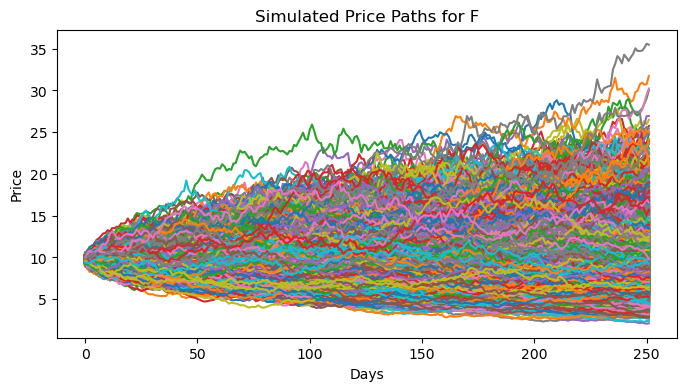

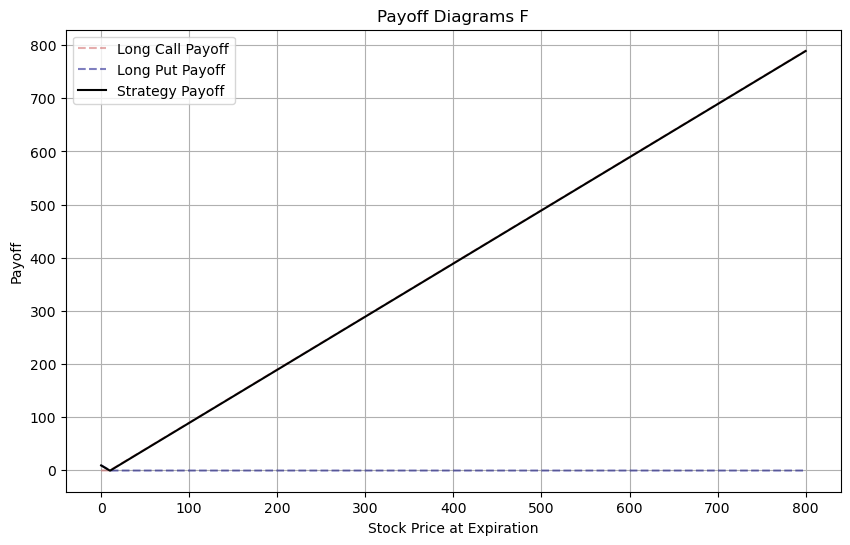

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.01
El rendimiento esperado de la estrategia es de 1.20%
La probabilidad de ganancia es de 43.71%
El intervalo de confianza del 95% para el profit es de [-0.823699640254563, 1.5047321076744335]



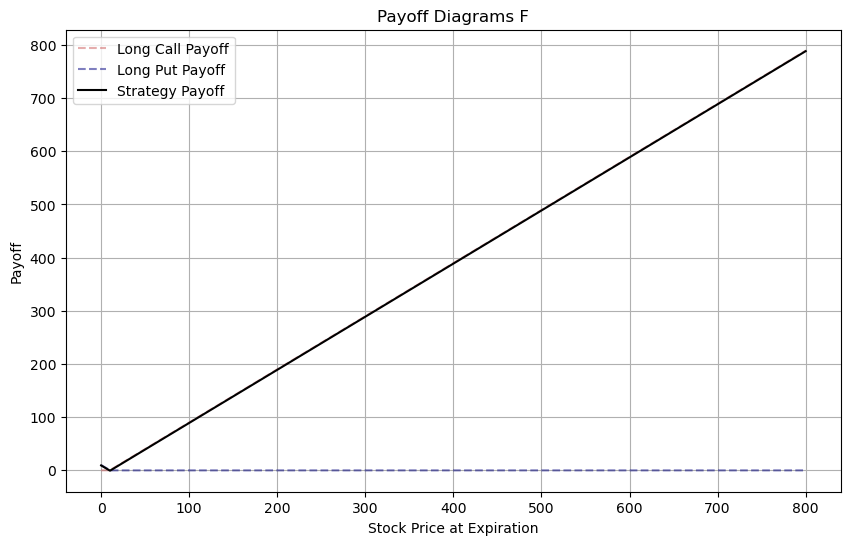

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $0.01
El rendimiento esperado de la estrategia es de 1.03%
La probabilidad de ganancia es de 43.40%
El intervalo de confianza del 95% para el profit es de [-1.4023463580122537, 2.598887463227522]



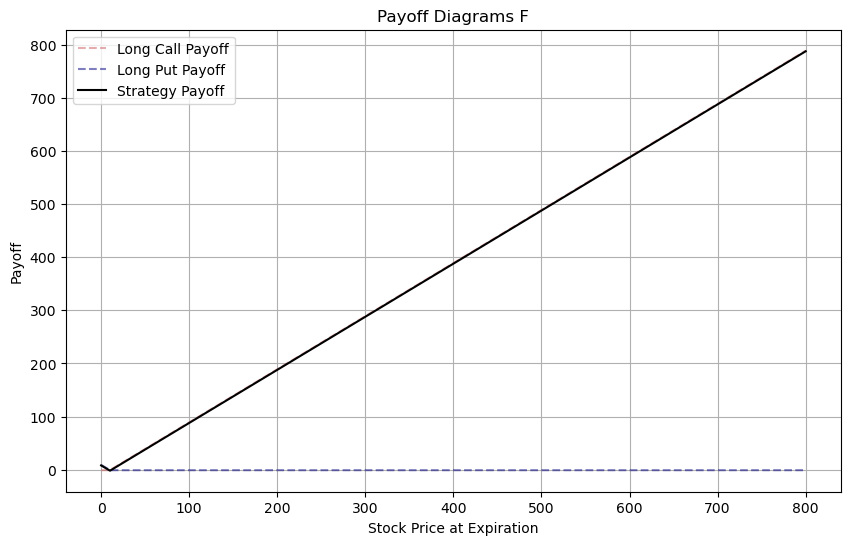

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $0.03
El rendimiento esperado de la estrategia es de 1.29%
La probabilidad de ganancia es de 43.47%
El intervalo de confianza del 95% para el profit es de [-1.9647572901776345, 3.6982537321370463]



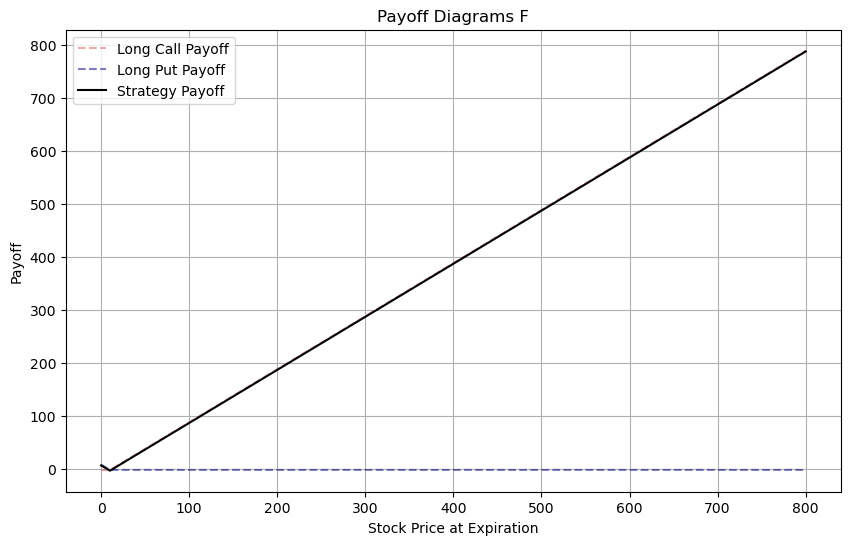

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $0.03
El rendimiento esperado de la estrategia es de 0.98%
La probabilidad de ganancia es de 43.16%
El intervalo de confianza del 95% para el profit es de [-2.7445079392726206, 5.650175977552623]



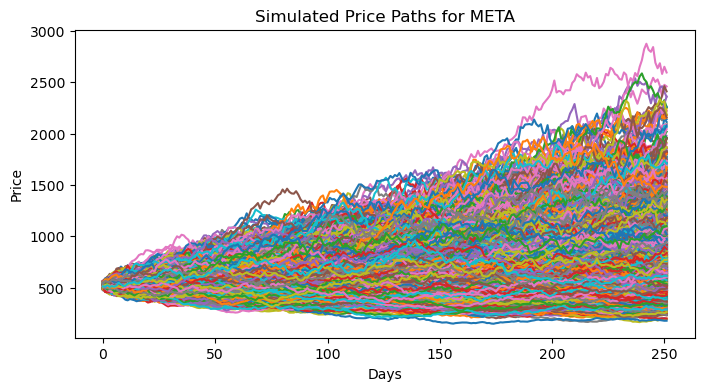

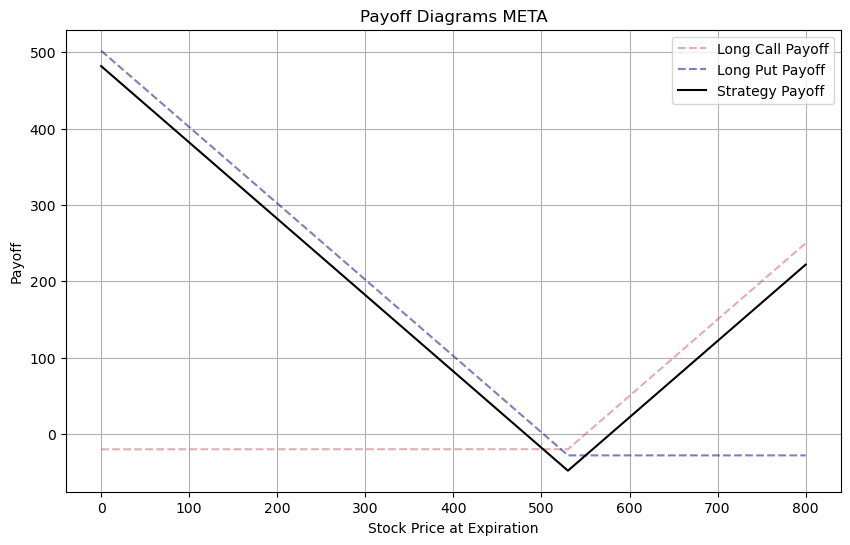

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.67
El rendimiento esperado de la estrategia es de 1.39%
La probabilidad de ganancia es de 42.62%
El intervalo de confianza del 95% para el profit es de [-46.38309675035538, 92.58087671995763]



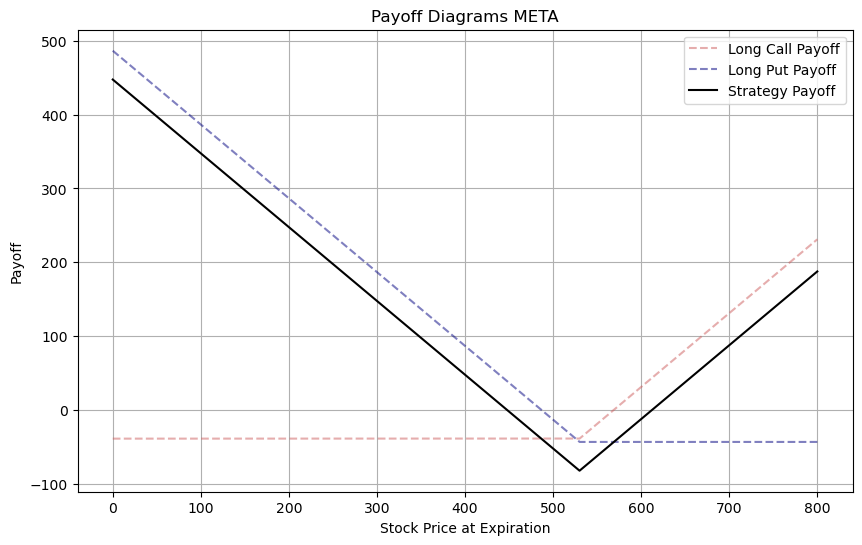

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $11.68
El rendimiento esperado de la estrategia es de 14.16%
La probabilidad de ganancia es de 45.94%
El intervalo de confianza del 95% para el profit es de [-79.07182655763133, 215.79116011757864]



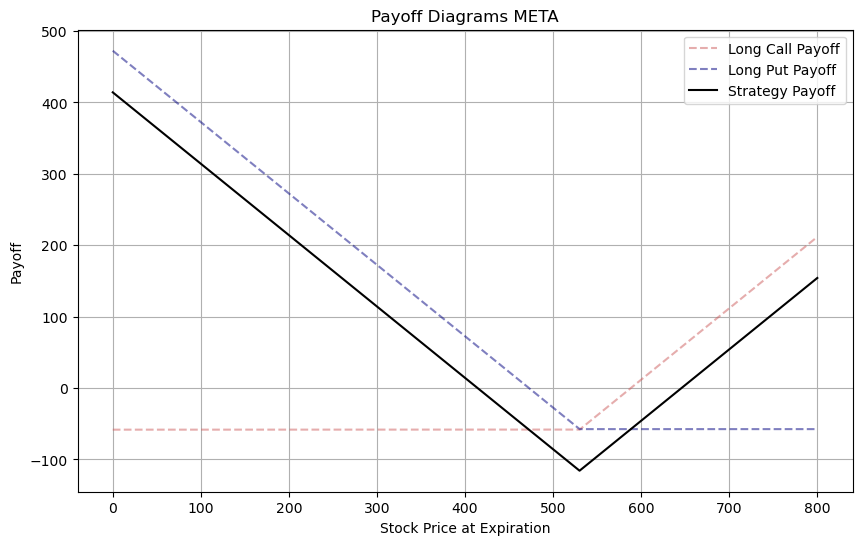

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $38.85
El rendimiento esperado de la estrategia es de 33.54%
La probabilidad de ganancia es de 50.29%
El intervalo de confianza del 95% para el profit es de [-110.67793000306399, 407.6943532821021]



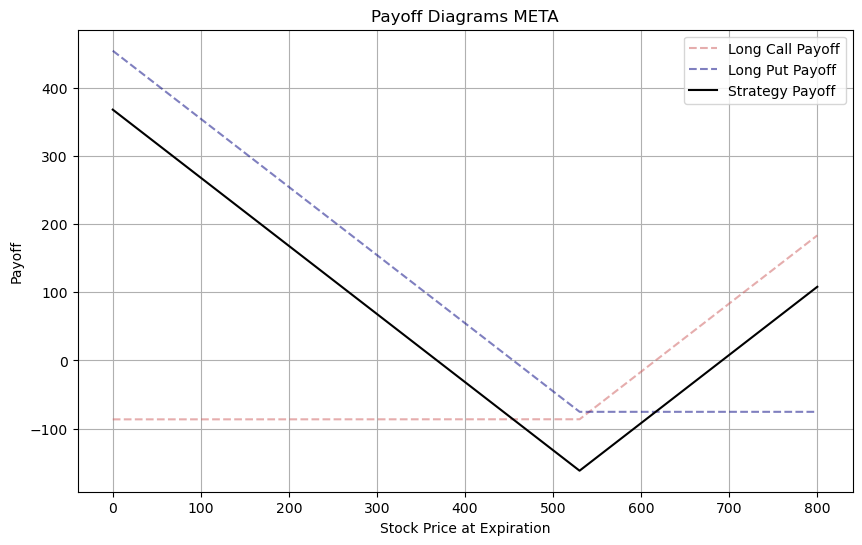

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $125.04
El rendimiento esperado de la estrategia es de 77.24%
La probabilidad de ganancia es de 57.78%
El intervalo de confianza del 95% para el profit es de [-153.4539443127653, 851.3407001056543]



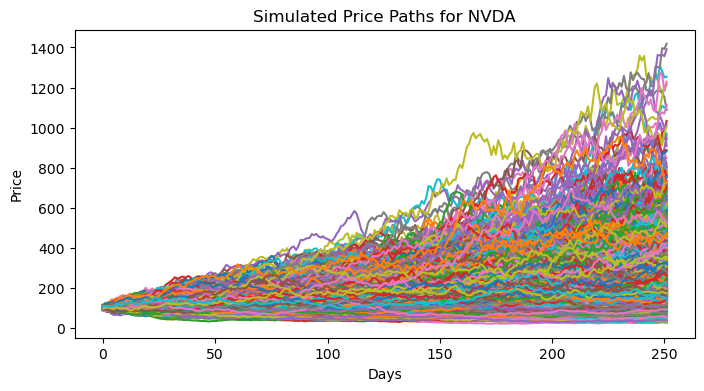

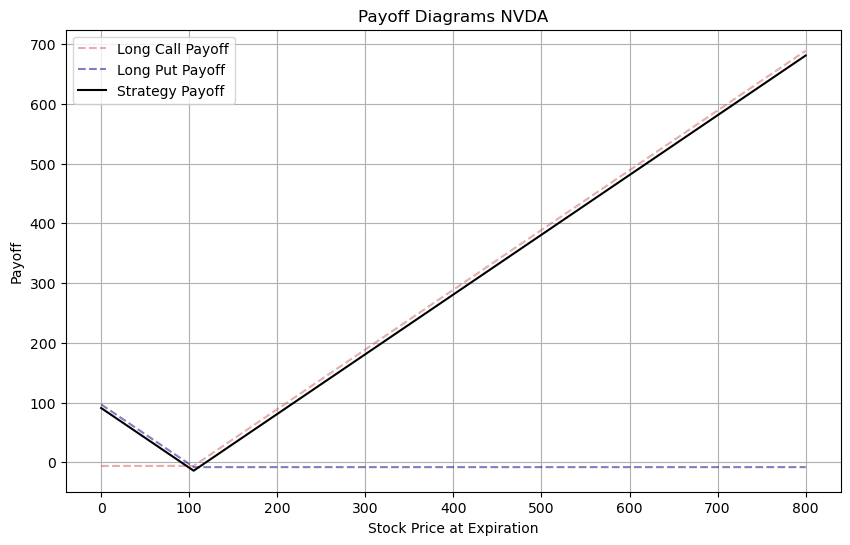

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $0.85
El rendimiento esperado de la estrategia es de 6.06%
La probabilidad de ganancia es de 43.56%
El intervalo de confianza del 95% para el profit es de [-13.472938369588247, 31.44276878227382]



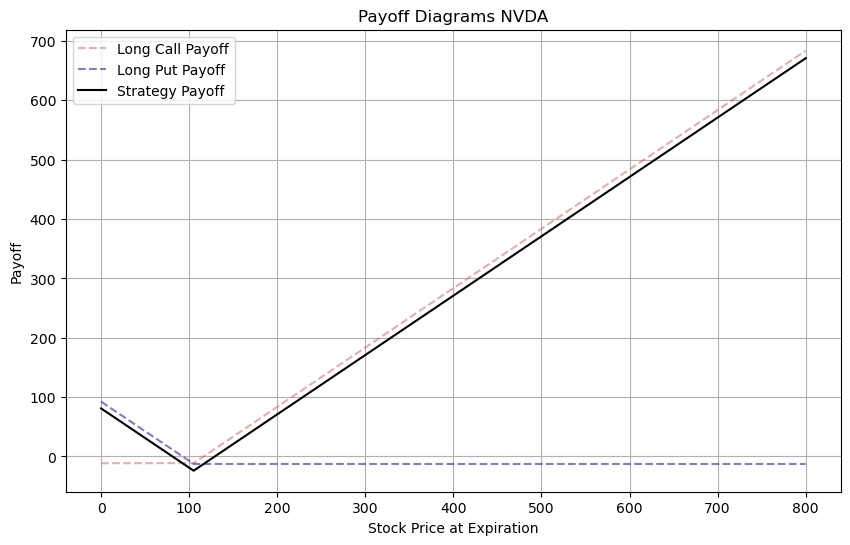

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $6.69
El rendimiento esperado de la estrategia es de 27.79%
La probabilidad de ganancia es de 48.35%
El intervalo de confianza del 95% para el profit es de [-22.994018923905966, 81.4313703989339]



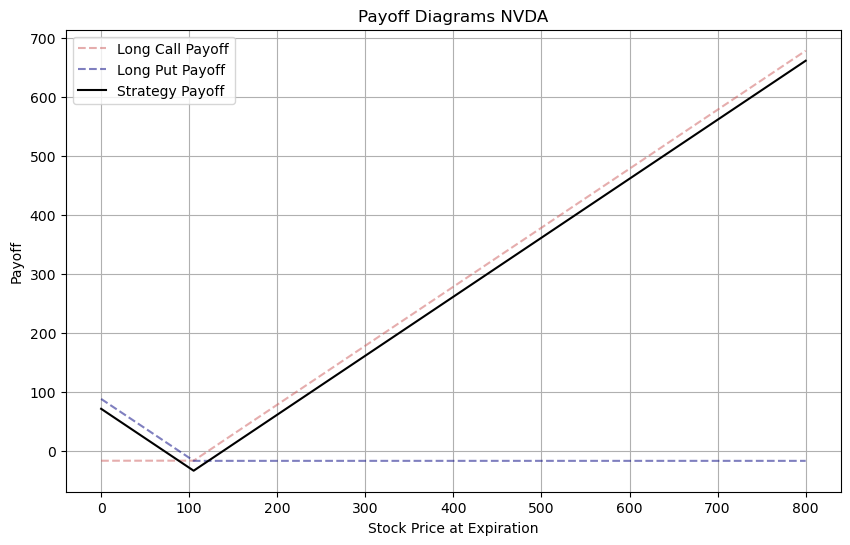

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $22.14
El rendimiento esperado de la estrategia es de 65.68%
La probabilidad de ganancia es de 54.87%
El intervalo de confianza del 95% para el profit es de [-32.04912765661612, 169.83614737442903]



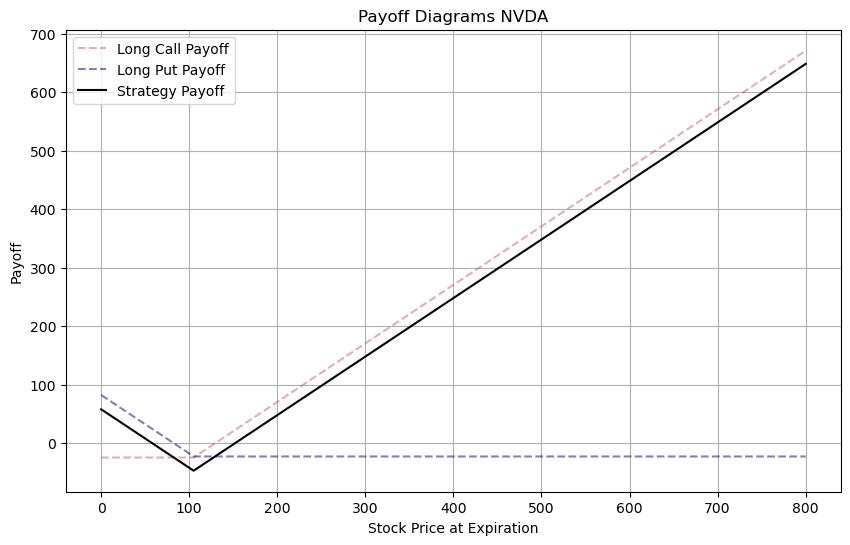

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $74.73
El rendimiento esperado de la estrategia es de 159.38%
La probabilidad de ganancia es de 65.28%
El intervalo de confianza del 95% para el profit es de [-43.95066332286239, 422.7573840764553]



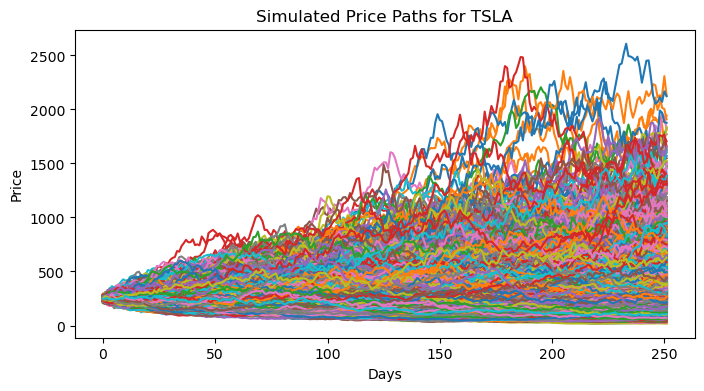

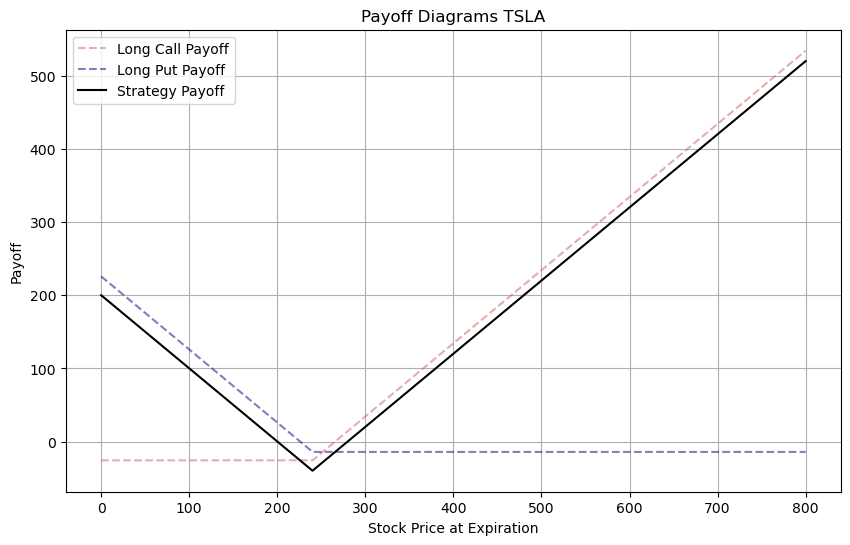

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $1.49
El rendimiento esperado de la estrategia es de 3.72%
La probabilidad de ganancia es de 41.95%
El intervalo de confianza del 95% para el profit es de [-38.383198299331355, 90.9562832970915]



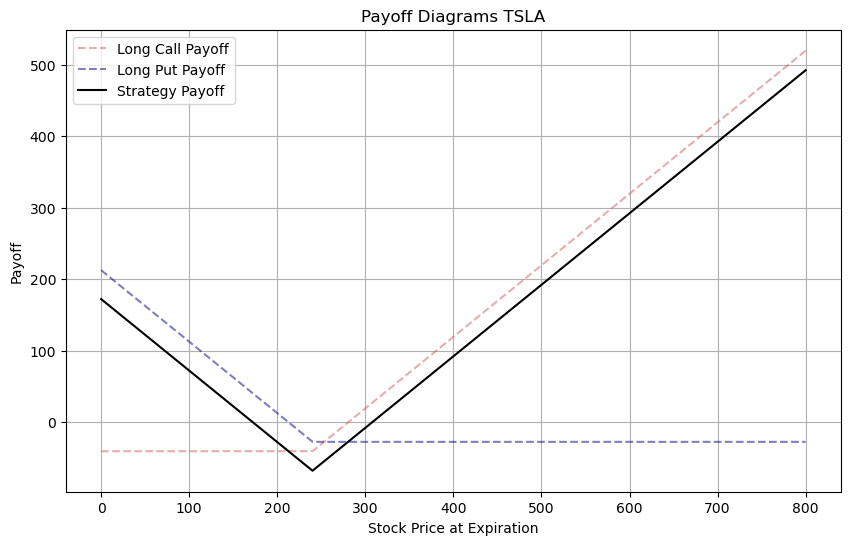

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $5.13
El rendimiento esperado de la estrategia es de 7.58%
La probabilidad de ganancia es de 41.91%
El intervalo de confianza del 95% para el profit es de [-65.01681544883706, 185.3829866048728]



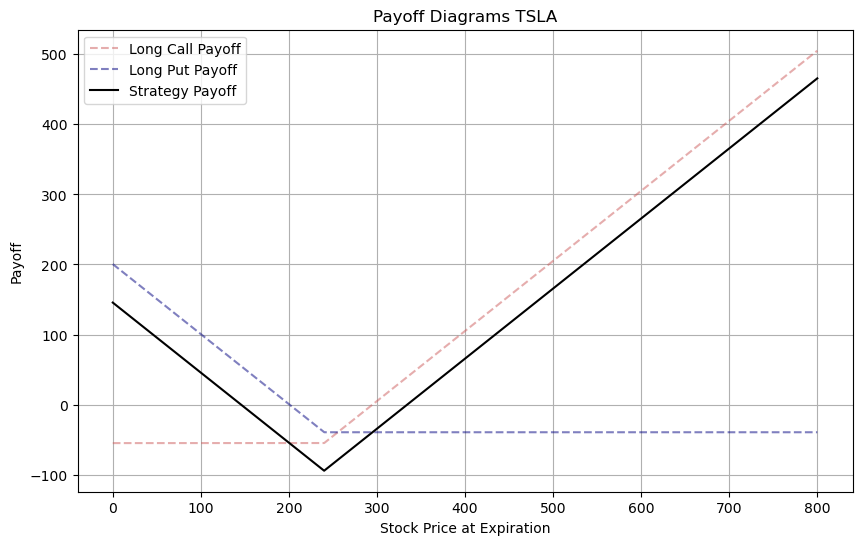

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $12.36
El rendimiento esperado de la estrategia es de 13.10%
La probabilidad de ganancia es de 41.30%
El intervalo de confianza del 95% para el profit es de [-90.68532435643843, 318.45273250717855]



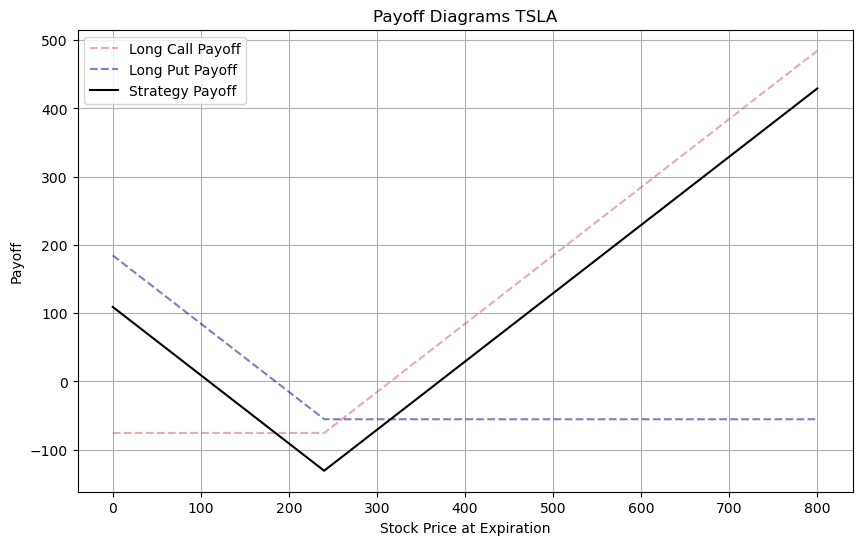

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $32.06
El rendimiento esperado de la estrategia es de 24.52%
La probabilidad de ganancia es de 40.11%
El intervalo de confianza del 95% para el profit es de [-125.39605604296209, 603.8804290287421]



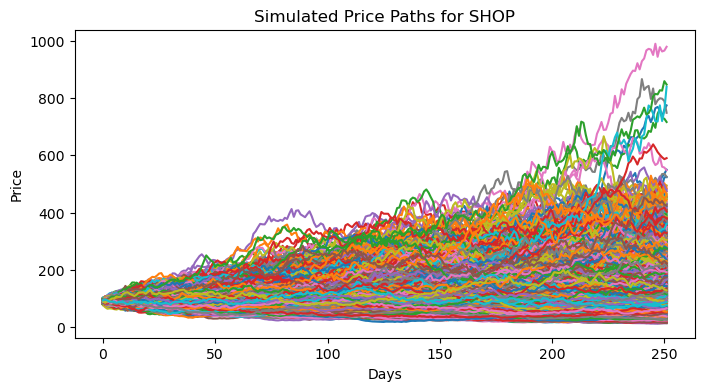

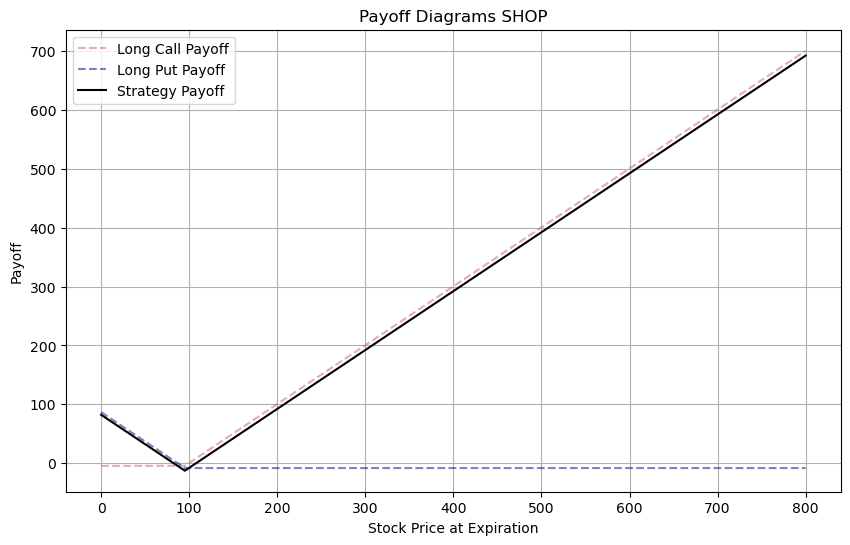

Las ganancias esperadas ejerciendo las opciones a los 21 días son:
El profit esperado es de $-0.10
El rendimiento esperado de la estrategia es de -0.80%
La probabilidad de ganancia es de 42.44%
El intervalo de confianza del 95% para el profit es de [-12.276682329879817, 22.50347801377066]



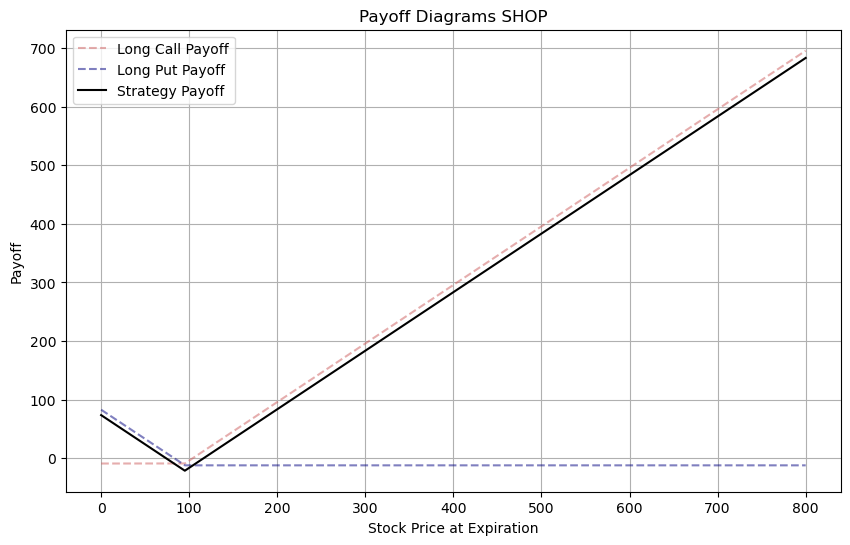

Las ganancias esperadas ejerciendo las opciones a los 63 días son:
El profit esperado es de $1.20
El rendimiento esperado de la estrategia es de 5.57%
La probabilidad de ganancia es de 43.31%
El intervalo de confianza del 95% para el profit es de [-20.710908722840585, 50.84974036657176]



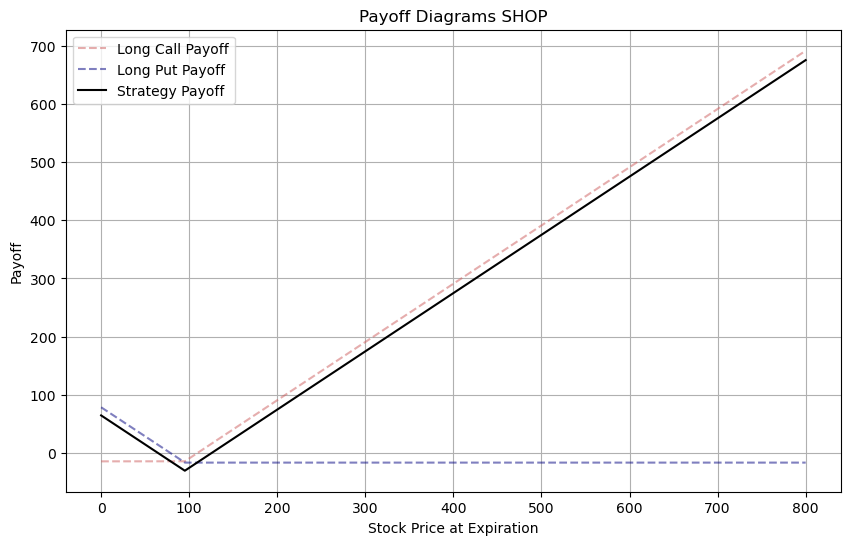

Las ganancias esperadas ejerciendo las opciones a los 126 días son:
El profit esperado es de $4.29
El rendimiento esperado de la estrategia es de 14.27%
La probabilidad de ganancia es de 43.63%
El intervalo de confianza del 95% para el profit es de [-28.811327586841653, 95.81077388536129]



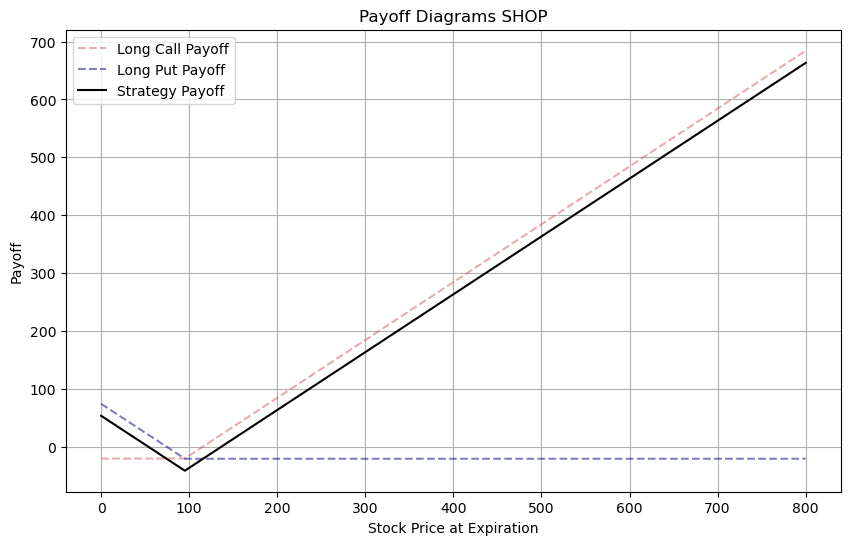

Las ganancias esperadas ejerciendo las opciones a los 252 días son:
El profit esperado es de $14.89
El rendimiento esperado de la estrategia es de 35.67%
La probabilidad de ganancia es de 45.15%
El intervalo de confianza del 95% para el profit es de [-39.977116573814826, 198.63843826627422]



In [7]:
straddle = MultiStraddle(tickers, start_date, end_date, strikes)
straddle.execute()